###Importar bibliotecas necessárias

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

###Clonar repositório do GitHub com o dataset

In [27]:
!git clone 'https://github.com/luan-satiro/AI_Or_Real.git'

fatal: destination path 'AI_Or_Real' already exists and is not an empty directory.


###Criando objeto Dataset

In [28]:
train_directory = '/content/AI_Or_Real/Images/train'
train_dataset = tf.keras.utils.image_dataset_from_directory(train_directory,
                                                            image_size=(160, 160),
                                                            shuffle=True)
test_directory = '/content/AI_Or_Real/Images/test'
validation_dataset = tf.keras.utils.image_dataset_from_directory(test_directory,
                                                                 image_size=(160, 160)
                                                                 ,shuffle=True)

Found 199 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


###Testando o train dataset

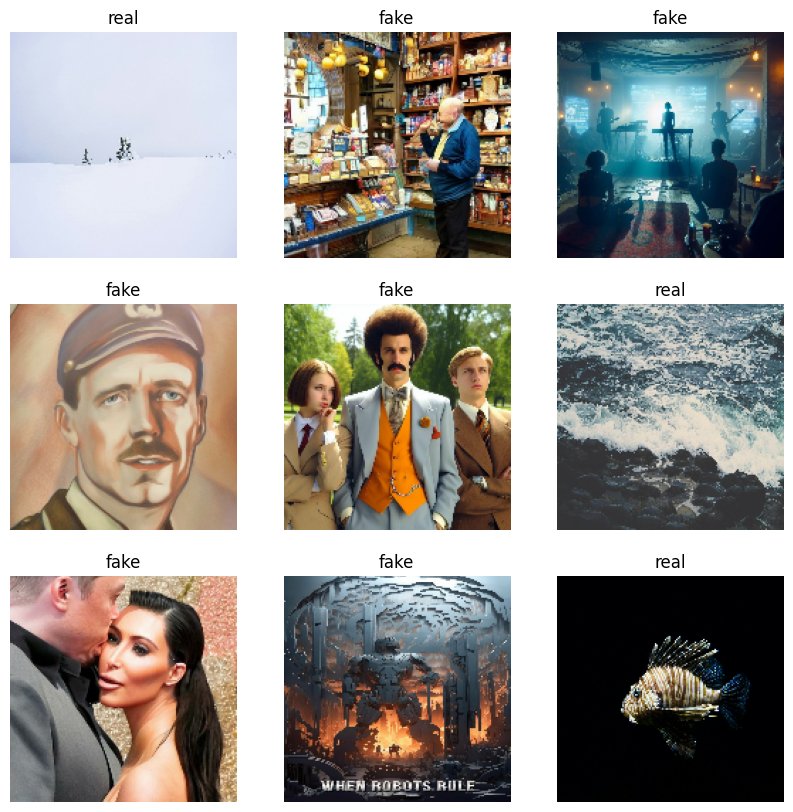

In [29]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

###Criando o dataset de teste

In [30]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [31]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 6
Number of test batches: 1


In [32]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [33]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

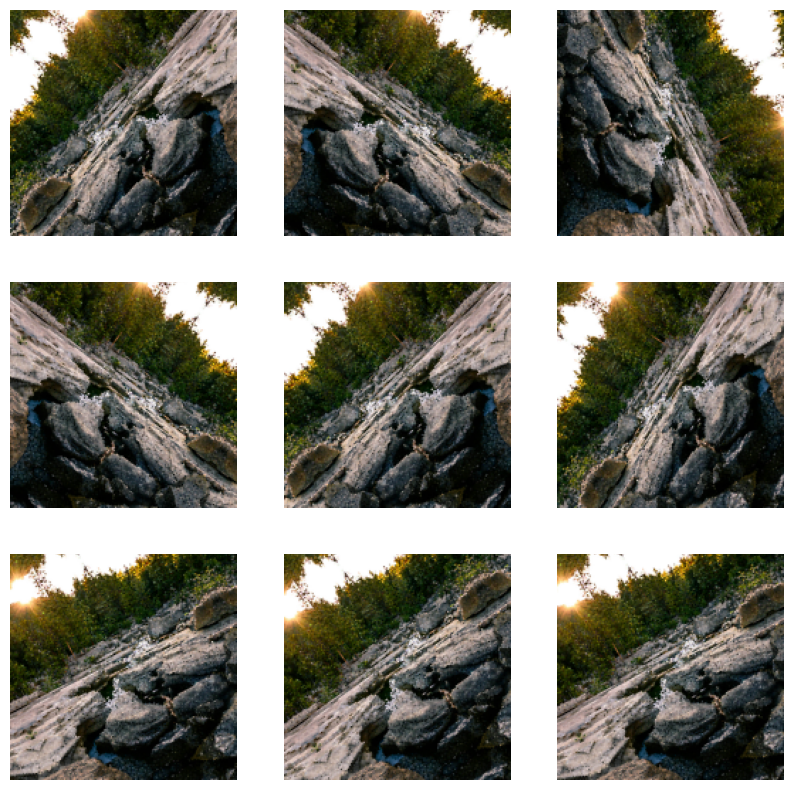

In [34]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [35]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

###Create the base model from the pre-trained convnets

In [36]:
# Create the base model from the pre-trained model MobileNet V2

IMG_SIZE = (160, 160)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [37]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [38]:
base_model.trainable = True

In [39]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [40]:
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 1,861,440 (7.10 MB)

 Non-trainable params: 396,544 (1.51 MB)

###Add a classification head

In [41]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


###Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image.

In [42]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


###Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API

In [43]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model =  tf.keras.Model(inputs, outputs)

In [44]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [45]:
len(model.trainable_variables)

56

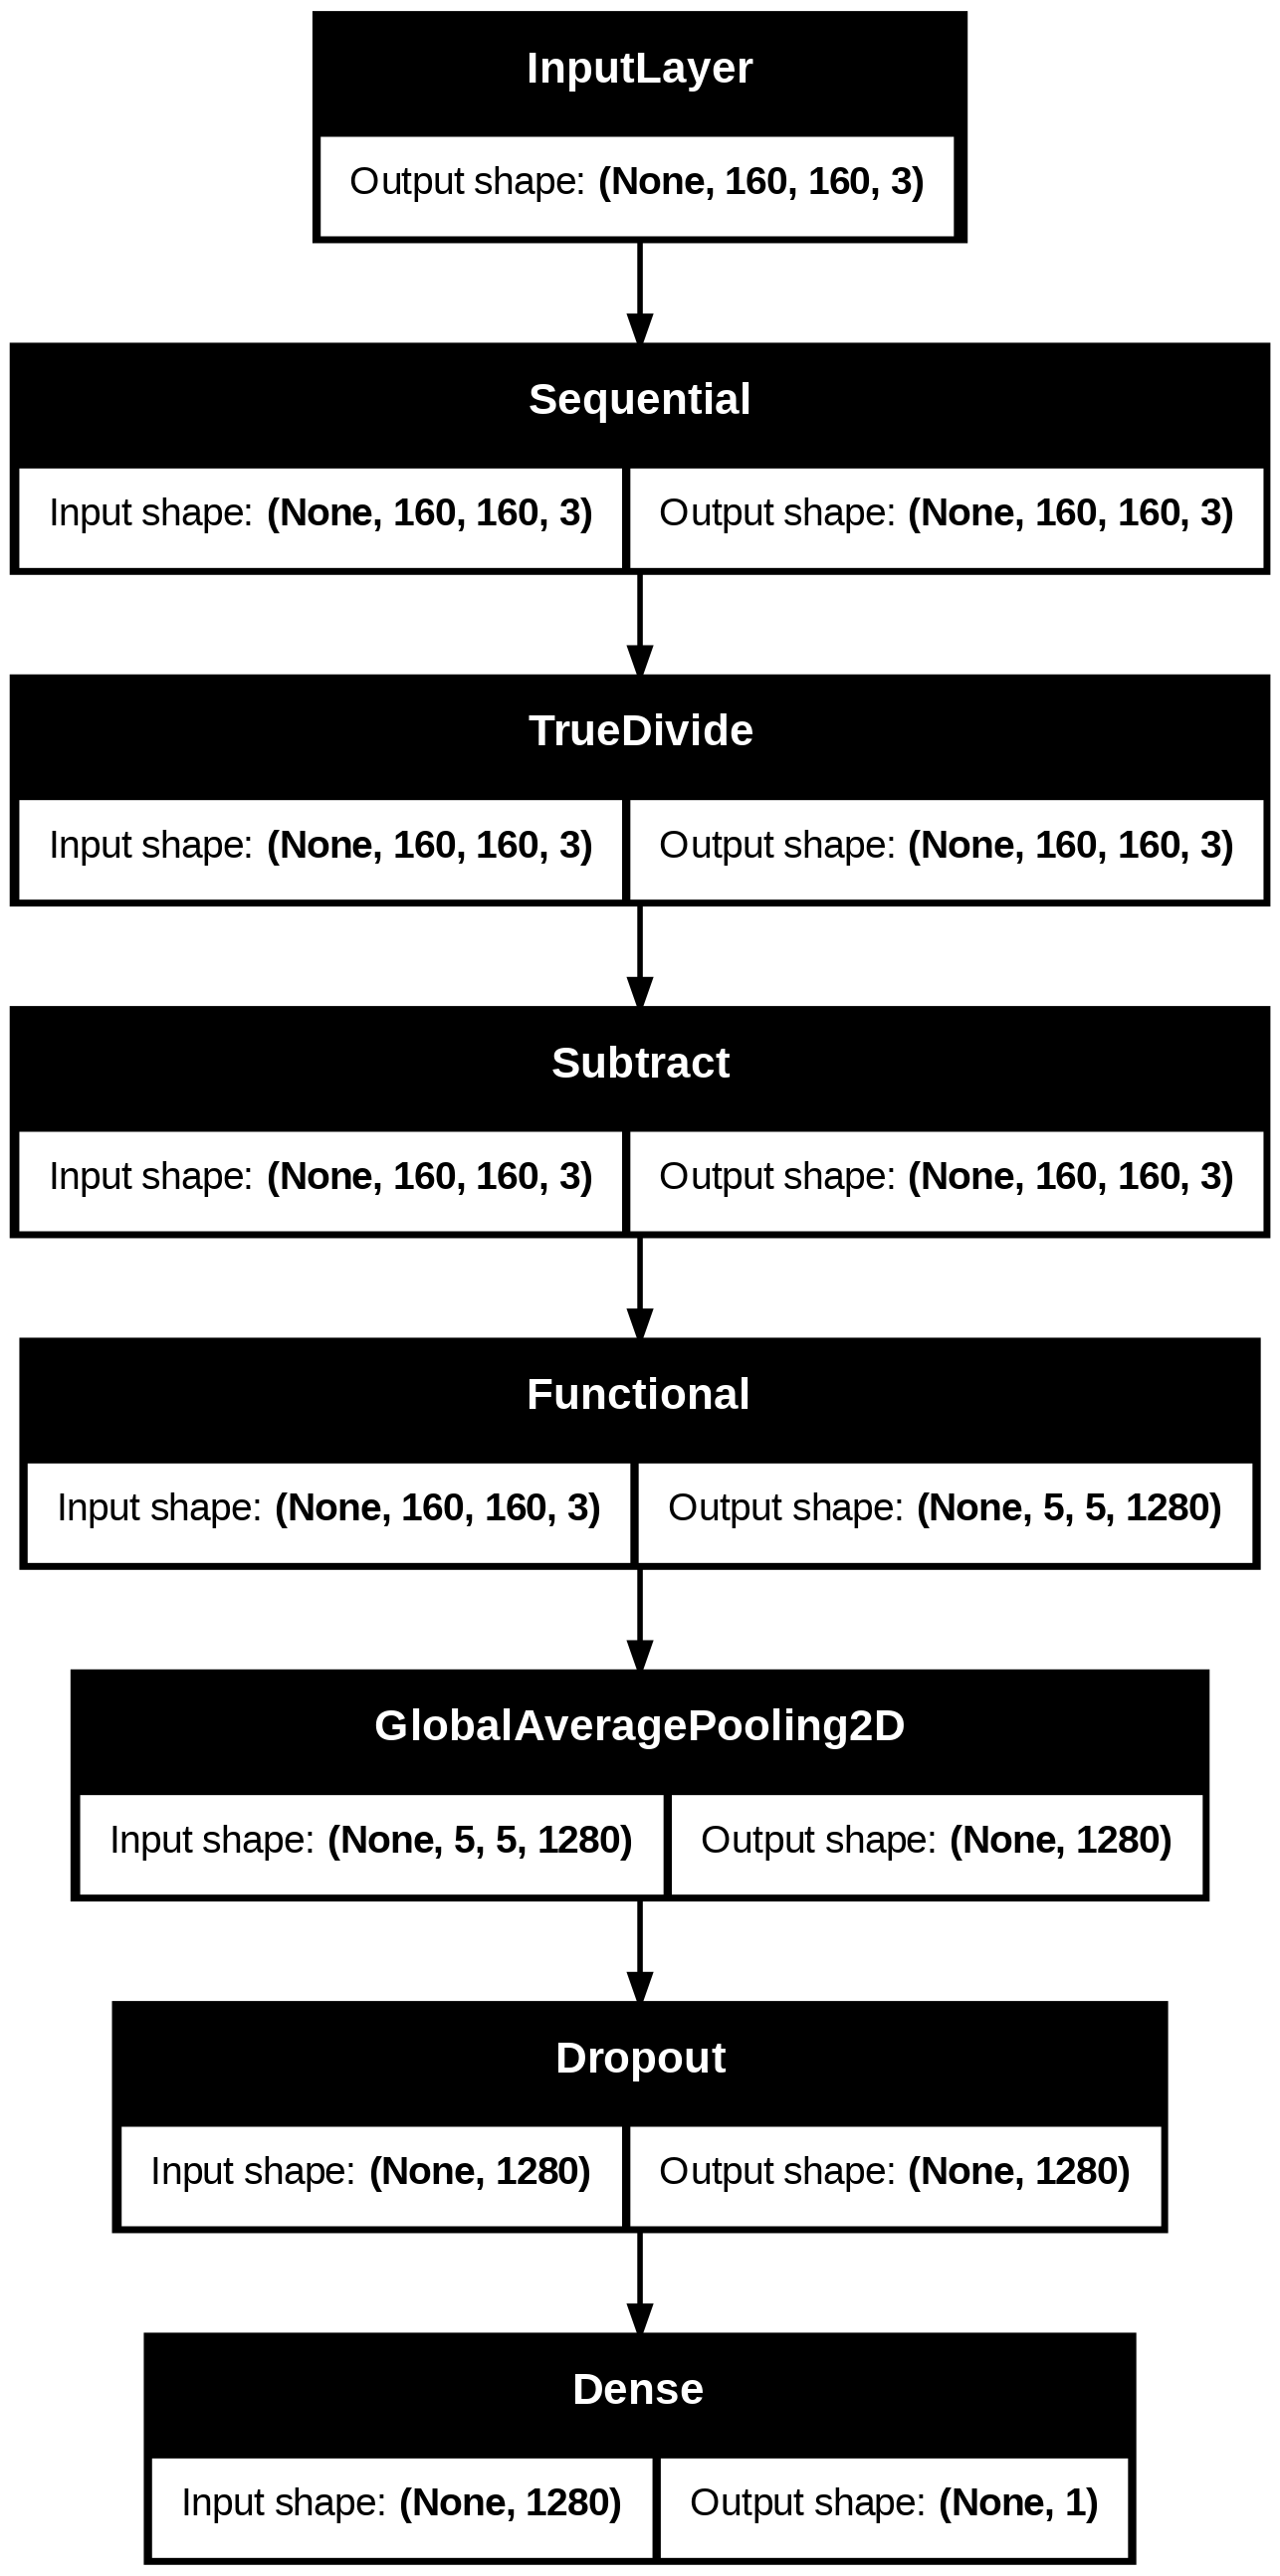

In [46]:
tf.keras.utils.plot_model(model, show_shapes=True)

###Compile the model before training it

In [47]:
base_learning_rate = 0.0001
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

###Train the model

In [48]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.3826 - loss: 1.0222


In [49]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.03
initial accuracy: 0.39


In [50]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 64s 8s/step - accuracy: 0.4570 - loss: 0.8777 - val_accuracy: 0.4464 - val_loss: 0.9531
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - accuracy: 0.5469 - loss: 0.7058 - val_accuracy: 0.4643 - val_loss: 0.9316
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 82s 7s/step - accuracy: 0.5891 - loss: 0.7299 - val_accuracy: 0.5357 - val_loss: 0.8657
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 83s 6s/step - accuracy: 0.6095 - loss: 0.6760 - val_accuracy: 0.5000 - val_loss: 0.9232
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 7s/step - accuracy: 0.6415 - loss: 0.6543 - val_accuracy: 0.5833 - val_loss: 0.8411
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 83s 7s/step - accuracy: 0.7504 - loss: 0.5420 - val_accuracy: 0.5655 - val_loss: 0.8922
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step - accuracy: 0.7321 - loss: 0.5524 - val_accuracy: 0.5893 - val_loss: 0.8378
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 83s 6s/step - accuracy: 0.7668 - loss: 0.4648 - val_accuracy: 0.5952 - val_loss: 0.8343
Epoch 9/

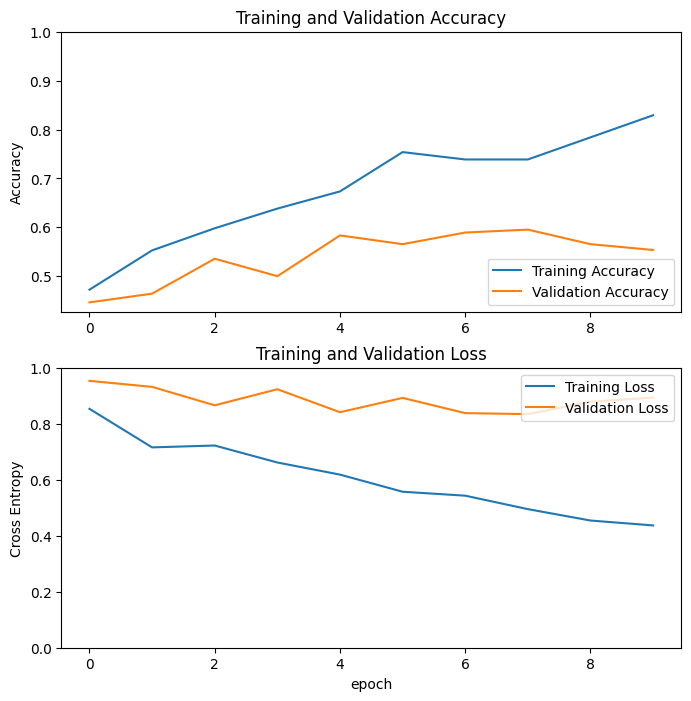

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [52]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 7s/step - accuracy: 0.7804 - loss: 0.4444 - val_accuracy: 0.5774 - val_loss: 0.8605
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 83s 7s/step - accuracy: 0.8254 - loss: 0.4181 - val_accuracy: 0.5952 - val_loss: 0.8687
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 81s 6s/step - accuracy: 0.8352 - loss: 0.3790 - val_accuracy: 0.6131 - val_loss: 0.8423
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 82s 7s/step - accuracy: 0.8685 - loss: 0.3414 - val_accuracy: 0.6131 - val_loss: 0.8749
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 88s 8s/step - accuracy: 0.8983 - loss: 0.3133 - val_accuracy: 0.5774 - val_loss: 0.9228
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - accuracy: 0.8731 - loss: 0.3332 - val_accuracy: 0.5774 - val_loss: 0.9282
Epoch 17/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 47s 7s/step - accuracy: 0.8818 - loss: 0.2985 - val_accuracy: 0.6012 - val_loss: 0.8956
Epoch 18/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 80s 7s/step - accuracy: 0.9197 - loss: 0.2748 - val_accuracy: 0.5952 - val_loss: 0.9301


In [53]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5625 - loss: 1.1341
Test accuracy : 0.5625


Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [1 1 0 1 1 1 0 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 0 1 0 1 1 1 0 1 1]


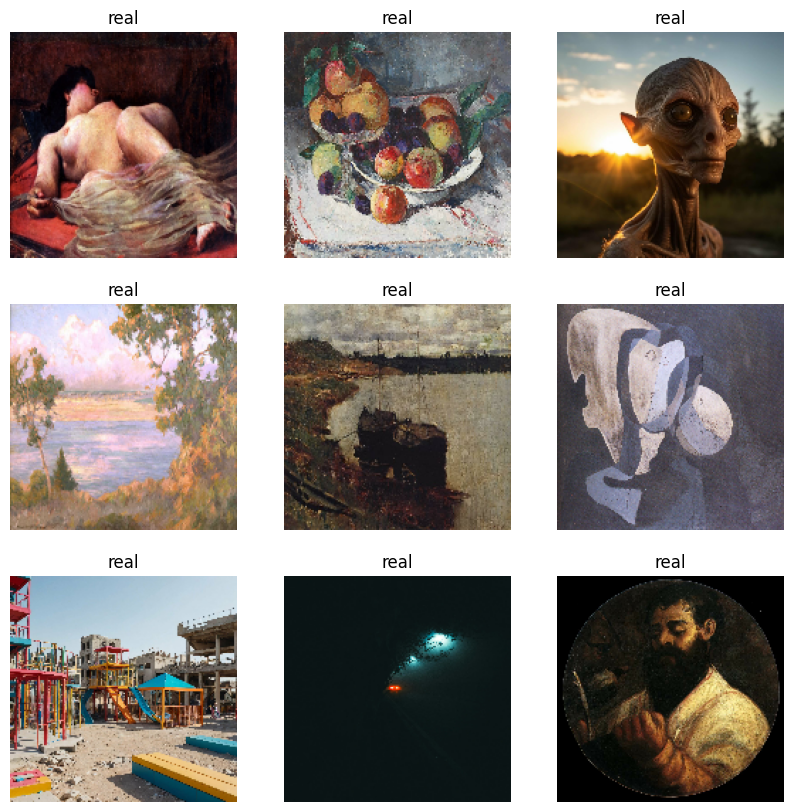

In [54]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")